In [12]:
from pylab import *

In [57]:
from tqdm import tqdm_notebook

In [179]:
rcParams['figure.figsize'] = 12,9
rcParams['axes.grid'] = True
rcParams['font.size'] = 18

In [47]:
import torch
from torch import optim, nn
import copy

In [88]:
class ZeroOutput(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.init_model = [copy.deepcopy(model).eval()]
        self.model = model
        
    def forward(self, inp):
        return self.model(inp) - self.init_model[0](inp)

In [89]:
class Scale(nn.Module):
    def __init__(self, model, alpha):
        super().__init__()
        self.model = model
        
    def forward(self, inp):
        return alpha*self.model(inp)

In [192]:
def gd(model, xdata, ydata, iters=100, lr=1e-3, alpha=1):
    opt = optim.SGD(model.parameters(), lr=lr)
    for i in range(iters):
        out = model(xdata)
        loss = 1/(alpha**2) * nn.MSELoss()(out, ydata)
        opt.zero_grad()
        loss.backward()
        opt.step()

In [73]:
x = torch.linspace(-5, 5, 1000).unsqueeze(1)

In [190]:
# xin = torch.tensor([-1.0e-2, 1e-2]).unsqueeze(1)
xin = torch.tensor([-0.5, 0.0, 0.5]).unsqueeze(1)
yin = torch.tensor([0.1, -0.1, 0.1]).unsqueeze(1)

In [205]:
model = f
inp = x

In [240]:
def ntk(model, inp):
    out = model(inp)
    p_vec = nn.utils.parameters_to_vector(model.parameters())
    p, = p_vec.shape
    batch, outdim = out.shape
    assert outdim == 1, "cant handle higher output dim than 1 for now"
    features = torch.zeros(batch, p, requires_grad=False)
    for i in range(batch):
        model.zero_grad()
        out[i].backward(retain_graph=True)
        p_grad = torch.tensor([], requires_grad=False)
        for p in model.parameters():
            p_grad = torch.cat((p_grad, p.grad.reshape(-1)))
        features[i, :] = p_grad

    tk = features @ features.t()
    return features, tk

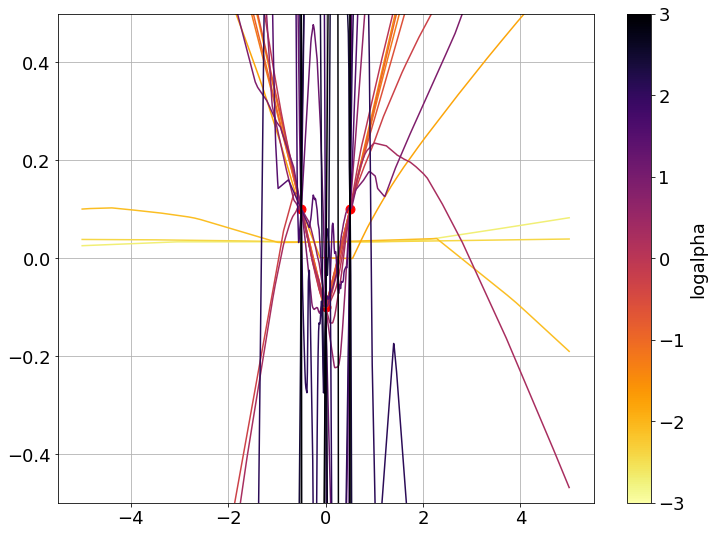

In [244]:
m = 100
# alpha = 1e-3
logalphas = linspace(-3, 3, 20)
alphas = 10**logalphas
b=True

colors = [get_cmap('inferno')(1. * i/len(alphas)) for i in range(len(alphas))][::-1]
plt.rc('axes', prop_cycle=cycler(color=colors))

for alpha in alphas:
    f1 = nn.Sequential(nn.Linear(1, m, bias=b), nn.ReLU(), nn.Linear(m, 1, bias=b))
    f2 = ZeroOutput(f1)
    f = Scale(f2, alpha)
#     f = f2
#     y0 = f1(x)
#     plot(x.detach(), y.detach())
    gd(f, xin, yin, alpha=alpha, iters=2000, lr=1e-1)
#     gd(f, xin, yin, alpha=1, iters=2000, lr=1e-3)
    y = f(x)
    plot(x.detach(), y.detach())

sm = cm.ScalarMappable(cmap=get_cmap('inferno_r'), norm=Normalize(vmin=logalphas[0], vmax=logalphas[-1]))
sm._A=[]
colorbar(sm, label='logalpha')
ylim(-0.5, 0.5)

scatter(xin, yin, color='red', s=80)
show()